In [2]:
import os

import cv2
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

In [220]:
imageA_path = os.path.join('results', 'GLM', 'ViT-B16', '0_simmap_with_0_2.png')
imageB_path = os.path.join('results', 'GLM', 'ViT-B16', '0_2_simmap_with_0.png')

heatmap1 = Image.open(imageA_path).convert('RGB')
heatmap2 = Image.open(imageB_path).convert('RGB')

red:  128.65081787109375  green:  175.69631958007812  blue:  124.21226501464844
red:  112.34697690977997  green:  80.29648184210896  blue:  111.7881572655102


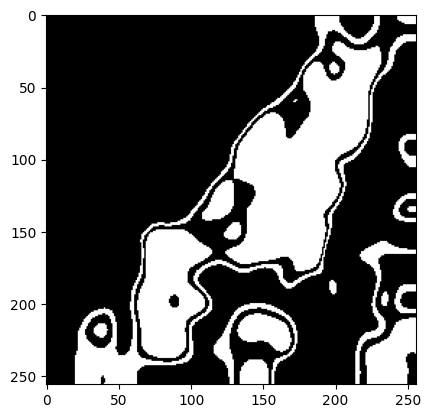

In [221]:
import numpy as np
from PIL import Image

def create_mask_rgb(image):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image, Image.Image):
        image = np.array(image.convert("RGB"))

    # Separar los canales
    red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]

    print('red: ', np.mean(red), ' green: ', np.mean(green), ' blue: ', np.mean(blue))
    print('red: ', np.std(red), ' green: ', np.std(green), ' blue: ', np.std(blue))

    # Aplicar las condiciones
    condition1 = (blue == 255) & (red == 0) & (green < 200)
    condition2 = (red == 0) & (green < 100)
    condition3 = (green == 255) & (blue > np.mean(blue))

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask = ((condition1 | condition2 | condition3) & (red <= np.mean(red)-np.std(red)*0.70))

    # print(np.mean(image[:,:,1]), np.mean(image[:,:,2]))
    # print(mask)

    return mask.astype(np.uint8)  # Convertir a 0 y 1

# Ejemplo de uso
mask = create_mask_rgb(heatmap1)
plt.imshow(mask, cmap="gray")
plt.show()

red:  132.34474182128906  green:  170.45962524414062  blue:  120.98219299316406
red:  110.42305028526535  green:  87.49687399971978  blue:  111.60985461373814


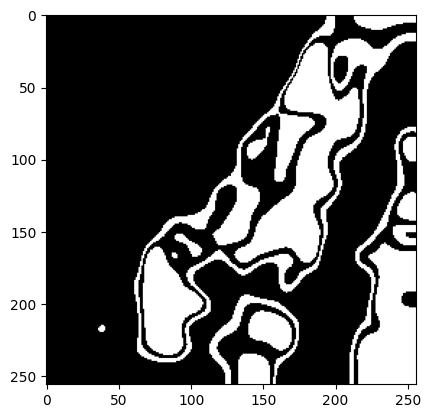

In [222]:
mask = create_mask_rgb(heatmap2)
plt.imshow(mask, cmap="gray")
plt.show()

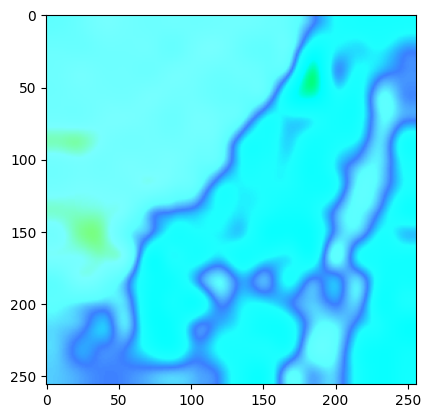

In [223]:
image = cv2.imread(imageB_path)
image_hsv1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plt.imshow(image_hsv1)

< 170, < 90 

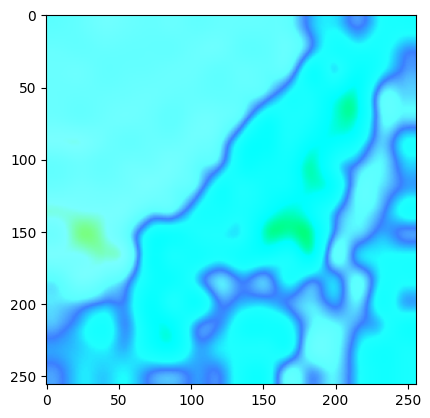

In [224]:
image = cv2.imread(imageA_path)
image_hsv2 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plt.imshow(image_hsv2)

In [225]:
diff = np.abs(np.array(image_hsv1)-np.array(image_hsv2))

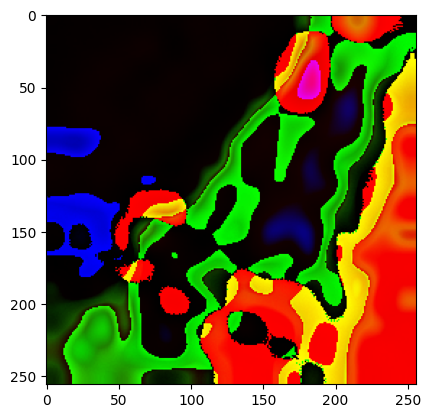

In [226]:
plt.imshow(diff)

255 0


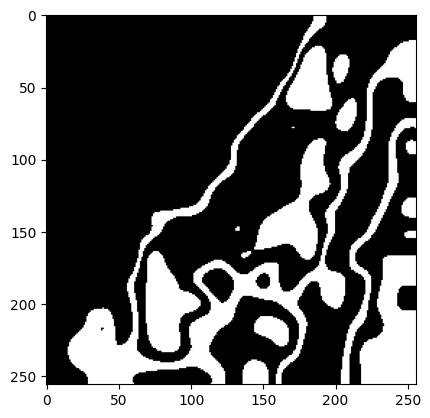

In [227]:
import numpy as np
from PIL import Image

def create_mask_hsv(image_hsv):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image_hsv, Image.Image):
        image_hsv = np.array(image_hsv.convert("RGB"))
        image_hsv = cv2.cvtColor(image_hsv, cv2.COLOR_RGB2HSV)

    # Separar los canales
    h, s, v = image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv[:, :, 2]

    # print('red: ', np.mean(v), ' green: ', np.mean(s), ' blue: ', np.mean(h))
    # print('red: ', np.std(v), ' green: ', np.std(s), ' blue: ', np.std(h))
    print(np.max(s), np.min(h))

    # Aplicar las condiciones
    condition1 = (h < 100) & (s > 0.5*255) & (v > 0.8*255)
    condition2 = (h < 10) & (s < 100) & (v == 255)
    condition3 = (h > 50) & (s < 0.8*255) & (s > 0.5*255)
    condition4 = (h > 100) & (s > 0.7*255) 
    

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask = condition3 | condition4

    # print(np.mean(image_hsv[:,:,1]), np.mean(image_hsv[:,:,2]))
    # print(mask)

    return mask.astype(np.uint8)  # Convertir a 0 y 1

# Ejemplo de uso
mask = create_mask_hsv(heatmap2)
plt.imshow(mask, cmap="gray")
plt.show()


In [228]:
import scipy.ndimage

In [229]:
def threshold(heatmap1, heatmap2):

    mask_rgb1 = create_mask_rgb(heatmap1)
    mask_rgb2 = create_mask_rgb(heatmap2)

    mask_hsv1 = create_mask_hsv(heatmap1)
    mask_hsv2 = create_mask_hsv(heatmap2)

    mask1 = mask_rgb1 & mask_hsv1
    mask2 = mask_rgb2 & mask_hsv2

    heatmap1_applyed_mask = heatmap1*mask1[:, :, np.newaxis]
    heatmap2_applyed_mask = heatmap2*mask2[:, :, np.newaxis]


    diff = np.abs(heatmap1_applyed_mask.astype(np.float32)-heatmap2_applyed_mask.astype(np.float32))

    print(np.max(diff), np.min(diff))
    
    r, g, b = diff[:, :, 0], diff[:, :, 1], diff[:, :, 2]

    condition1 = (b > 220) & (r <20) & (g < 150) & (r != 255) & (g != 255)
    condition2 = (b < 220) & (r == 0) & (g == 0)
    condition3 = (b < 10) & (r < 50) & (g < 50)
    condition4 = (r < 150) & (g == 255) & (b > 100)

    diff_mask = (condition1 & ~condition2 & ~condition3) | condition4

    labeled_mask, num_features = scipy.ndimage.label(diff_mask)
    counts = np.bincount(labeled_mask.ravel())[1:]

    print(np.where(counts >= 300)[0]+1)
    print(np.unique(labeled_mask))
    filtered_mask = np.where(np.isin(labeled_mask, np.where(counts >= 300)[0]+1), 1, 0)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes[0,0].imshow(mask_rgb1, cmap="gray")
    axes[0,0].set_title("Heatmap 1 RGB")

    axes[0,1].imshow(mask_hsv1, cmap="gray")
    axes[0,1].set_title("Heatmap 1 HSV")

    axes[1,0].imshow(mask_rgb2, cmap="gray")
    axes[1,0].set_title("Heatmap 2 RGB")

    axes[1,1].imshow(mask_hsv2, cmap="gray")
    axes[1,1].set_title("Heatmap 2 HSV")

    axes[0,2].imshow(heatmap1_applyed_mask, cmap="gray")
    axes[0,2].set_title("Heatmap 1")

    axes[1,2].imshow(heatmap2_applyed_mask, cmap="gray")
    axes[1,2].set_title("Heatmap 2")

    axes[2,0].imshow(diff, cmap="gray")
    axes[2,0].set_title("Diff")

    axes[2,1].imshow(diff_mask, cmap="gray")
    axes[2,1].set_title("Diff Mask")

    axes[2,2].imshow(filtered_mask, cmap="gray")
    axes[2,2].set_title("Filtered Mask")

    for ax in axes.flat:
        ax.axis("off")

    plt.show()

    return diff_mask
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


red:  128.65081787109375  green:  175.69631958007812  blue:  124.21226501464844
red:  112.34697690977997  green:  80.29648184210896  blue:  111.7881572655102
red:  132.34474182128906  green:  170.45962524414062  blue:  120.98219299316406
red:  110.42305028526535  green:  87.49687399971978  blue:  111.60985461373814
255 0
255 0
255.0 0.0
[ 13  21  94 110]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 15

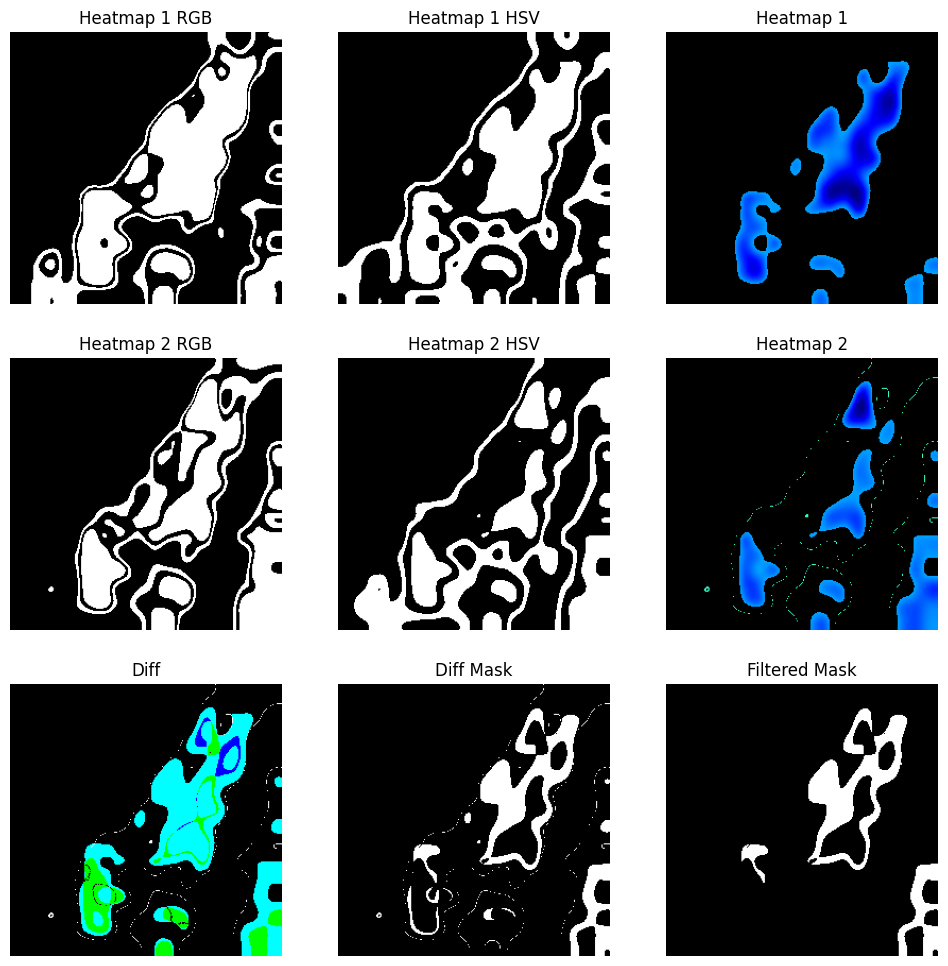

In [230]:
diff_mask = threshold(heatmap1, heatmap2)

Número de regiones conectadas: 22
Pixeles en cada región: [   2    1    1    2    2    2    2   13   76 1514  218   17    2  152
   34    1    6    1   53    1   17    1]


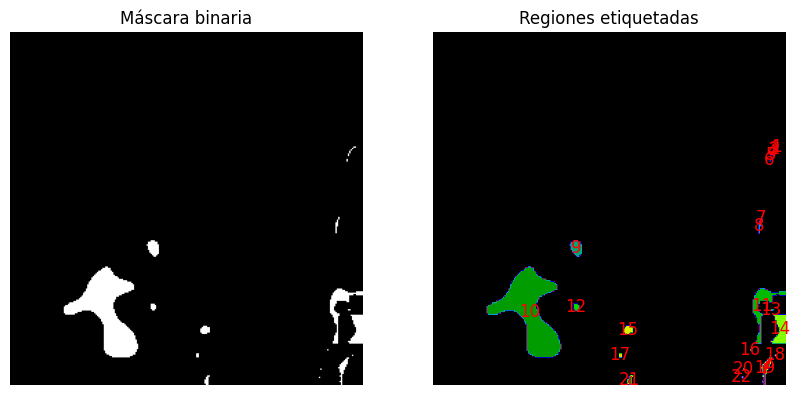

In [251]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# Crear una máscara binaria (0 = negro, 1 = blanco)
mask = np.random.randint(0, 2, (10, 10))  # Ejemplo de máscara binaria

# Etiquetar las regiones conectadas
labeled_mask, num_features = scipy.ndimage.label(diff_mask)

# Contar los píxeles de cada región
counts = np.bincount(labeled_mask.ravel())[1:]  # Ignorar el fondo (índice 0)

# Mostrar resultados
print("Número de regiones conectadas:", num_features)
print("Pixeles en cada región:", counts)

# Visualizar la máscara original y la etiquetada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(diff_mask, cmap="gray")
axes[0].set_title("Máscara binaria")
axes[0].axis("off")

ax1 = axes[1]
ax1.imshow(labeled_mask, cmap="nipy_spectral")
ax1.set_title("Regiones etiquetadas")
ax1.axis("off")

# Agregar números en el centro de cada región
for region_label in range(1, num_features + 1):
    pos = np.argwhere(labeled_mask == region_label).mean(axis=0)  # Encontrar centroide
    ax1.text(pos[1], pos[0], str(region_label), color="red", fontsize=12, ha="center", va="center")

plt.show()


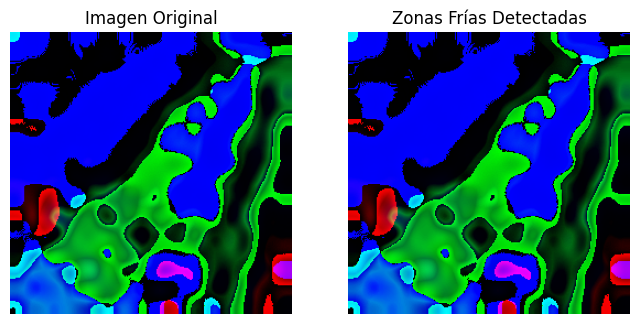

In [184]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 🔹 1. Cargar la imagen en RGB
image = cv2.imread(imageB_path)
image_rgb = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

# 🔹 2. Convertir a HSV para filtrar colores fríos
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# 🔹 3. Definir rangos de colores fríos en HSV
# Azul oscuro
lower_blue_dark = np.array([200, 55, 35])  # (H, S, V)
upper_blue_dark = np.array([260, 255, 150])

# Azul claro / verdoso
lower_blue_light = np.array([80, 50, 50])
upper_blue_light = np.array([160, 255, 255])

# 🔹 4. Crear máscaras para los colores fríos
mask_blue_dark = cv2.inRange(image_hsv, lower_blue_dark, upper_blue_dark)
mask_blue_light = cv2.inRange(image_hsv, lower_blue_light, upper_blue_light)

# Combinar máscaras
mask_cold_areas = cv2.bitwise_or(mask_blue_dark, mask_blue_light)

# 🔹 5. Encontrar contornos en las zonas frías
contornos, _ = cv2.findContours(mask_cold_areas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 🔹 6. Dibujar contornos en la imagen original
image_with_contours = image_rgb.copy()
for i, cnt in enumerate(contornos):
    # Obtener área del contorno
    area = cv2.contourArea(cnt)
    if 40 > area > 2000:  # Filtrar contornos pequeños
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_with_contours, (x, y), (x + w, y + h), (255, 255, 255), 2)
        cv2.putText(image_with_contours, f"Zona fria", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

# 🔹 7. Mostrar resultados
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Imagen Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image_with_contours)
plt.title("Zonas Frías Detectadas")
plt.axis("off")

plt.show()


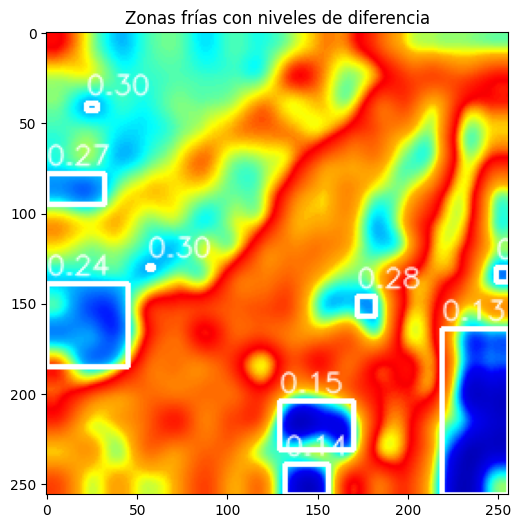

Contorno 0: Diferencia media = 0.1421, Numero de pixeles = 357
Contorno 1: Diferencia media = 0.1536, Numero de pixeles = 763
Contorno 2: Diferencia media = 0.1270, Numero de pixeles = 2475
Contorno 3: Diferencia media = 0.2834, Numero de pixeles = 67
Contorno 4: Diferencia media = 0.2418, Numero de pixeles = 1400
Contorno 5: Diferencia media = 0.2652, Numero de pixeles = 52
Contorno 6: Diferencia media = 0.2980, Numero de pixeles = 4
Contorno 7: Diferencia media = 0.2665, Numero de pixeles = 419
Contorno 8: Diferencia media = 0.2980, Numero de pixeles = 18


In [185]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 🔹 1. Cargar el heatmap en escala de grises
heatmap = cv2.imread(imageB_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0  # Normalizar [0,1]

# 🔹 2. Aplicar umbral para detectar zonas frías (ejemplo: < 0.3)
umbral_frio = 0.3
binario_frio = (heatmap < umbral_frio).astype(np.uint8) * 255  # Convertir a imagen binaria

# 🔹 3. Encontrar contornos en las zonas frías
contornos, _ = cv2.findContours(binario_frio, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 🔹 4. Calcular el nivel de diferencia de cada contorno
niveles_diferencia = []
heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)

for i, cnt in enumerate(contornos):
    # Crear una máscara para el contorno actual
    mascara = np.zeros_like(heatmap, dtype=np.uint8)
    cv2.drawContours(mascara, [cnt], -1, color=255, thickness=cv2.FILLED)

    # Extraer los valores de diferencia dentro del contorno
    valores_contorno = heatmap[mascara == 255]
    
    if 0 < len(valores_contorno):
        
        media_diferencia = np.mean(valores_contorno)  # Promedio de los valores dentro del contorno
        niveles_diferencia.append((i, media_diferencia, len(valores_contorno)))

        # Dibujar rectángulo con el nivel de diferencia
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(heatmap_color, (x, y), (x + w, y + h), (255, 255, 255), 2)
        cv2.putText(heatmap_color, f"{media_diferencia:.2f}", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

# 🔹 5. Mostrar resultados
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB))
plt.title("Zonas frías con niveles de diferencia")
plt.show()

# 🔹 6. Imprimir los niveles de diferencia
for i, nivel, n_pixel in niveles_diferencia:
    print(f"Contorno {i}: Diferencia media = {nivel:.4f}, Numero de pixeles = {n_pixel}")


Porcentaje de alta diferencia en la región seleccionada: 45.02%


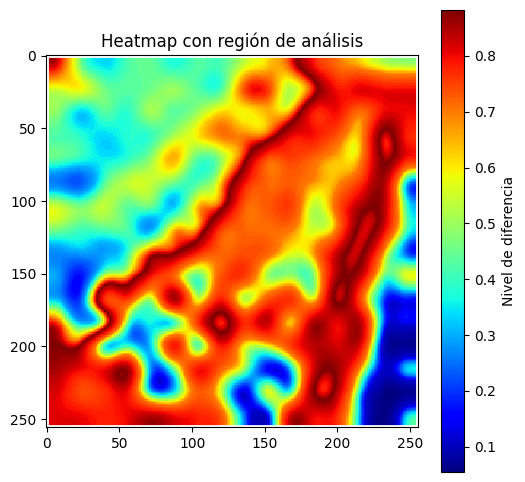

In [186]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 🔹 1. Cargar el heatmap (puede ser una imagen o una matriz)
heatmap = cv2.imread(imageA_path, cv2.IMREAD_GRAYSCALE)  # Imagen en escala de grises

# Si el heatmap viene como una matriz NumPy, normalizamos a [0,1]
heatmap = heatmap.astype(np.float32) / 255.0  

# 🔹 2. Definir la región de interés (ROI)
x1, y1, x2, y2 = 0, 0, 255, 255  # Coordenadas (izq, arriba, der, abajo)
roi = heatmap[y1:y2, x1:x2]  # Extraer área

# 🔹 3. Aplicar un umbral para detectar concentración de diferencias
umbral = 0.7  # Valores mayores a esto se consideran "diferencias altas"
pixeles_diferentes = np.sum(roi > umbral)  # Cuenta píxeles sobre el umbral
porcentaje_diferencia = (pixeles_diferentes / roi.size) * 100

print(f"Porcentaje de alta diferencia en la región seleccionada: {porcentaje_diferencia:.2f}%")

# 🔹 4. Mostrar el heatmap con la región seleccionada
plt.figure(figsize=(6,6))
plt.imshow(heatmap, cmap="jet", interpolation="nearest")  # Colormap tipo heatmap
plt.colorbar(label="Nivel de diferencia")

# Dibujar la región seleccionada
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='white', facecolor='none')
plt.gca().add_patch(rect)

plt.title("Heatmap con región de análisis")
plt.show()


In [187]:
def threshold(heatmap1, heatmap2):
    # Normalización a [0,1]
    # heatmap1 = (heatmap1 - np.min(heatmap1)) / (np.max(heatmap1) - np.min(heatmap1))
    # heatmap2 = (heatmap2 - np.min(heatmap2)) / (np.max(heatmap2) - np.min(heatmap2))

    # Calcular la diferencia absoluta
    # diff_map = np.abs(np.array(heatmap1) - np.array(heatmap2))
    # print(diff_map)

    # Umbral fijo
    # threshold = 254
    # diff_mask = diff_map > threshold

    # Umbral basad en la media y la desviación estandard
    threshold = np.array([0, 0, 150]) 
    print(threshold,np.mean(np.array(heatmap1)[:,:,2]), np.std(np.array(heatmap1)[:,:,2]))  # Ajusta el factor según necesidad
    heatmap1_mask = heatmap1 < threshold

    threshold = np.array([0, 0, 150]) 
    print(threshold,np.mean(np.array(heatmap2)[:,:,2]), np.std(np.array(heatmap2)[:,:,2]))  # Ajusta el factor según necesidad
    heatmap2_mask = heatmap2 < threshold

    # Convertir diff_mask a uint8 (0 y 255)
    # heatmap1_mask = (heatmap1_mask * 255).astype(np.uint8)
    # mask_single_channel1 = np.all(heatmap1_mask != 0, axis=-1).astype(np.uint8)
    
    # heatmap1_img = Image.fromarray(heatmap1_mask, mode='L')

    # heatmap2_mask = (heatmap2_mask * 255).astype(np.uint8)
    # mask_single_channel2 = np.all(heatmap1_mask != 0, axis=-1).astype(np.uint8)

    # heatmap2_img = Image.fromarray(heatmap2_mask, mode='L')

    # plt.figure(figsize=(10, 5))  # Tamaño de la figura

    # plt.subplot(1, 2, 1)  # Primera imagen en una grilla de 1 fila, 2 columnas
    # plt.imshow(heatmap1_mask, cmap="gray")
    # plt.title("Heatmap 1")
    # plt.axis("off")

    # plt.subplot(1, 2, 2)  # Segunda imagen
    # plt.imshow(heatmap2_mask, cmap="gray")
    # plt.title("Heatmap 2")
    # plt.axis("off")

    # plt.show()


    heatmap1_applyed_mask = heatmap1*heatmap1_mask
    heatmap2_applyed_mask = heatmap2*heatmap2_mask

    plt.figure(figsize=(10, 5))  # Tamaño de la figura

    plt.subplot(1, 2, 1)  # Primera imagen en una grilla de 1 fila, 2 columnas
    plt.imshow(heatmap1_applyed_mask, cmap="gray")
    plt.title("Heatmap 1")
    plt.axis("off")

    plt.subplot(1, 2, 2)  # Segunda imagen
    plt.imshow(heatmap2_applyed_mask, cmap="gray")
    plt.title("Heatmap 2")
    plt.axis("off")

    plt.show()

    diff = np.abs(heatmap1_applyed_mask+heatmap2_applyed_mask)[:,:,2]
    diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
    diff_mask = (diff * 255).astype(np.uint8)
    print(np.mean(diff_mask), np.std(diff_mask))
    diff_mask = diff_mask>(np.mean(diff_mask)+np.std(diff_mask))
    plt.imshow(diff_mask, cmap="gray")

    # print(heatmap1_applyed_mask.shape)

    # plt.figure(figsize=(10, 5))  # Tamaño de la figura

    # plt.subplot(1, 3, 1)  # Primera imagen en una grilla de 1 fila, 2 columnas
    # plt.imshow(diff, cmap="gray")
    # plt.title("Heatmap 1")
    # plt.axis("off")

    # plt.subplot(1, 3, 2)  # Segunda imagen
    # plt.imshow(Image.fromarray(diff[:,:,1], mode='L'), cmap="gray")
    # plt.title("Heatmap 2")
    # plt.axis("off")

    # plt.subplot(1, 3, 3)  # Segunda imagen
    # plt.imshow(Image.fromarray(diff[:,:,2], mode='L'), cmap="gray")
    # plt.title("Heatmap 2")
    # plt.axis("off")

    # plt.show()

[  0   0 150] 115.85333251953125 106.65320025387125
[  0   0 150] 100.077880859375 104.5694101695822


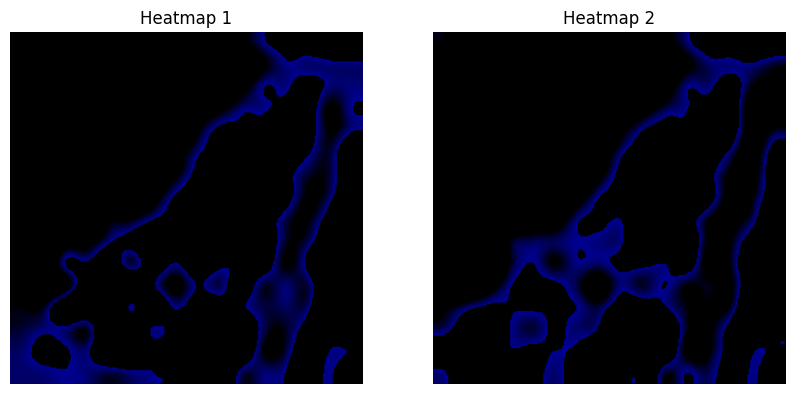

31.98565673828125 58.84641934651257


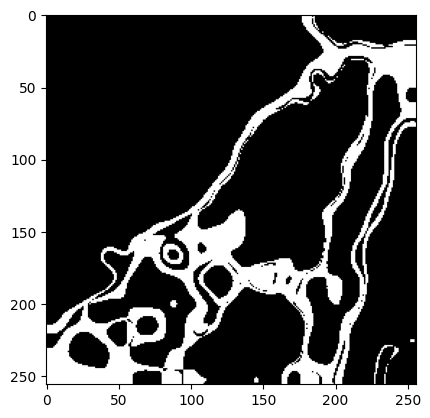

In [188]:
threshold(heatmap1, heatmap2)

red:  136.7866973876953  green:  167.03817749023438  blue:  115.85333251953125
red:  107.18524300953086  green:  93.45901116959027  blue:  106.65320025387125
167.03817749023438 115.85333251953125
[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


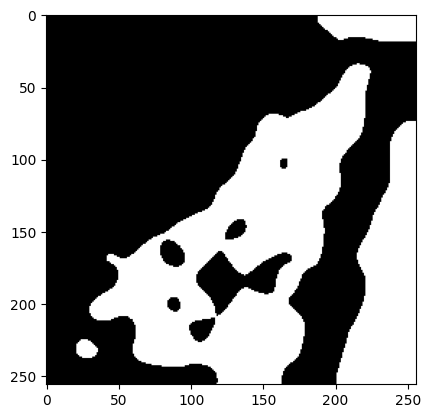

In [189]:
import numpy as np
from PIL import Image

def create_mask(image):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image, Image.Image):
        image = np.array(image.convert("RGB"))

    # Separar los canales
    red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]

    print('red: ', np.mean(red), ' green: ', np.mean(green), ' blue: ', np.mean(blue))
    print('red: ', np.std(red), ' green: ', np.std(green), ' blue: ', np.std(blue))

    # Aplicar las condiciones
    condition4 = (red < 0.3*255) & (green > 0.5*255) & (blue > 0.7*255) & (red > 0)
    condition1 = (blue == 255) & (red == 0)
    condition2 = (red == 0) & (green < 100)

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask =  condition4 | condition1 | condition2

    print(np.mean(image[:,:,1]), np.mean(image[:,:,2]))
    print(mask)

    return mask.astype(np.uint8)  # Convertir a 0 y 1

# Ejemplo de uso
mask = create_mask(heatmap1)
plt.imshow(mask, cmap="gray")
plt.show()

red:  152.12063598632812  green:  170.06663513183594  blue:  100.077880859375
red:  105.80605136547037  green:  88.91711011942893  blue:  104.5694101695822
170.06663513183594 100.077880859375
[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


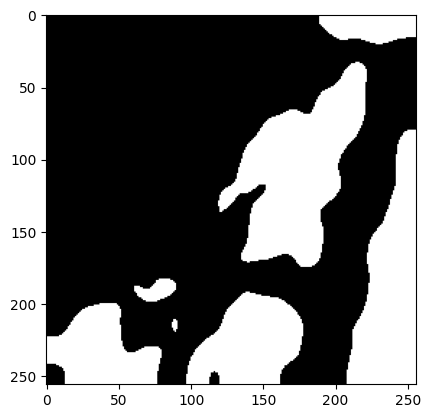

In [190]:
mask = create_mask(heatmap2)
plt.imshow(mask, cmap="gray")
plt.show()

red:  136.7866973876953  green:  167.03817749023438  blue:  115.85333251953125
red:  107.18524300953086  green:  93.45901116959027  blue:  106.65320025387125
167.03817749023438 115.85333251953125
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


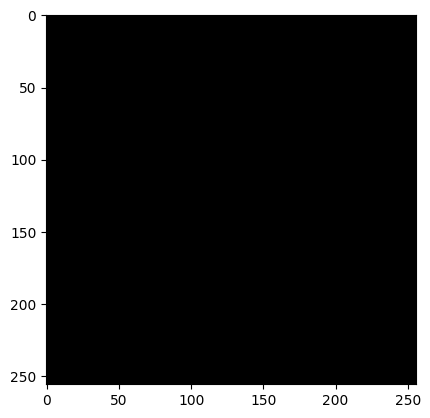

In [191]:
import numpy as np
from PIL import Image

def create_mask(image):
    # Convertir a NumPy si es una imagen PIL
    if isinstance(image, Image.Image):
        image = np.array(image.convert("RGB"))

    # Separar los canales
    red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]

    print('red: ', np.mean(red), ' green: ', np.mean(green), ' blue: ', np.mean(blue))
    print('red: ', np.std(red), ' green: ', np.std(green), ' blue: ', np.std(blue))

    # Aplicar las condiciones
    # condition1 = (green < 100) & (green > 50) & (blue == 255) & (red == 0)
    # condition2 = (blue < 230) & (green == 0) & (red == 0)
    # condition3 = (red != 255) 
    condition4 = (green != 0) & (blue != 0) & (red < 0)
    condition5 = (blue > np.mean(blue)+2*np.std(blue)) & (green == 255) & (red < np.mean(red)-2*np.std(red))

    # Crear la máscara combinada (True donde se cumple alguna de las condiciones)
    mask =  condition4 | condition5

    print(np.mean(image[:,:,1]), np.mean(image[:,:,2]))
    print(mask)

    return mask.astype(np.uint8)  # Convertir a 0 y 1

# Ejemplo de uso
mask = create_mask(heatmap1)
plt.imshow(mask, cmap="gray")
plt.show()


red:  152.12063598632812  green:  170.06663513183594  blue:  100.077880859375
red:  105.80605136547037  green:  88.91711011942893  blue:  104.5694101695822
170.06663513183594 100.077880859375
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


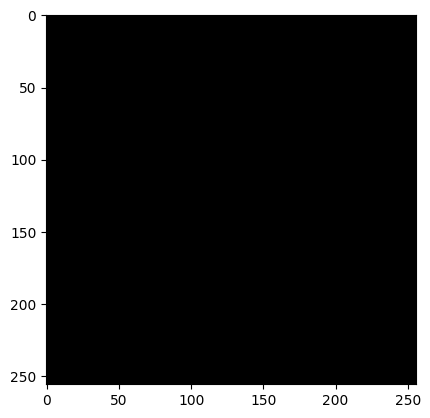

In [192]:
mask = create_mask(heatmap2)
plt.imshow(mask, cmap="gray")
plt.show()

In [193]:
def threshold(heatmap1, heatmap2):


    heatmap1_applyed_mask = heatmap1*create_mask(heatmap1)[:, :, np.newaxis]
    heatmap2_applyed_mask = heatmap2*create_mask(heatmap2)[:, :, np.newaxis]

    plt.figure(figsize=(10, 5))  # Tamaño de la figura

    plt.subplot(1, 2, 1)  # Primera imagen en una grilla de 1 fila, 2 columnas
    plt.imshow(heatmap1_applyed_mask, cmap="gray")
    plt.title("Heatmap 1")
    plt.axis("off")

    plt.subplot(1, 2, 2)  # Segunda imagen
    plt.imshow(heatmap2_applyed_mask, cmap="gray")
    plt.title("Heatmap 2")
    plt.axis("off")

    plt.show()

    diff = np.abs(heatmap1_applyed_mask-heatmap2_applyed_mask)
    plt.imshow(diff, cmap="gray")
    print(np.mean(diff[:,:,2]), np.std(diff[:,:,2]), np.mean(diff[:,:,1]), np.std(diff[:,:,1]))

    red, green, blue = diff[:, :, 0], diff[:, :, 1], diff[:, :, 2]

    print('red: ', np.mean(red), ' green: ', np.mean(green), ' blue: ', np.mean(blue))

    condition1 = (green < 255) & (blue == 255) & (red == 0)
    condition2 = (blue < 150) & (blue < 150) & (green == 0) & (red == 0) & (blue != 0)
    condition3 = (red < 0.3*255) & (green > 0.7*255) & (blue == 255)
    condition4 = (red < 0.3*255) & (green < 0.7*255) & (blue < 0.5*255) & (red != 0)

    diff_mask = condition3 |condition4

    print(diff_mask)

    diff_mask.astype(np.uint8)

    # diff_mask = (diff[:,:,2]>0) & (diff[:,:,2]<255) & (diff[:,:,1]==0) & (diff[:,:,1]<255) 
    plt.imshow(diff_mask, cmap="gray")

red:  136.7866973876953  green:  167.03817749023438  blue:  115.85333251953125
red:  107.18524300953086  green:  93.45901116959027  blue:  106.65320025387125
167.03817749023438 115.85333251953125
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
red:  152.12063598632812  green:  170.06663513183594  blue:  100.077880859375
red:  105.80605136547037  green:  88.91711011942893  blue:  104.5694101695822
170.06663513183594 100.077880859375
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


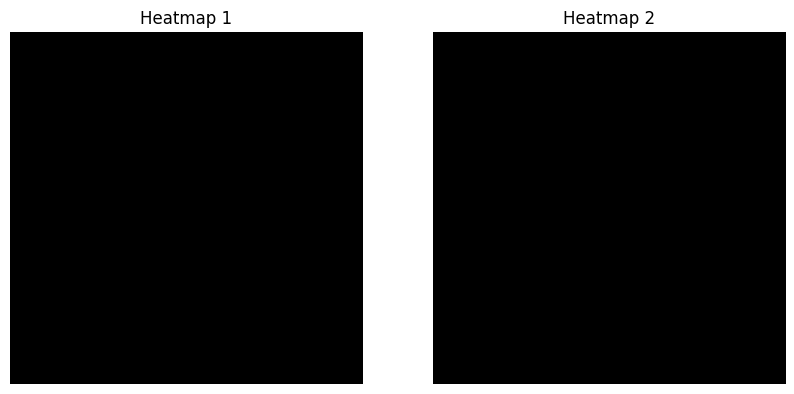

0.0 0.0 0.0 0.0
red:  0.0  green:  0.0  blue:  0.0
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


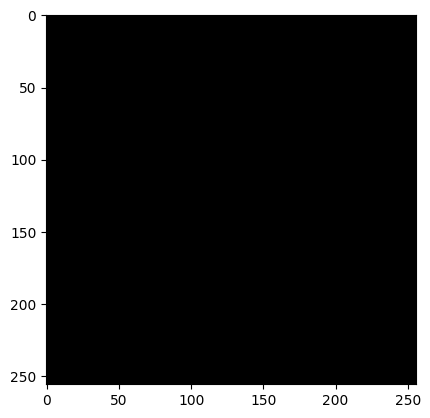

In [194]:
threshold(heatmap1, heatmap2)

0, 0_2 
- Mask: 
    - C1 = (green < 100) & (green > 50) & (blue == 255) & (red == 0)
    - C2 = (blue < 230) & (green == 0) & (red == 0)

    - red:  128.65081787109375  green:  175.69631958007812  blue:  124.21226501464844
        red:  112.34697690977997  green:  80.29648184210896  blue:  111.7881572655102
    - red:  132.34474182128906  green:  170.45962524414062  blue:  120.98219299316406
        red:  110.42305028526535  green:  87.49687399971978  blue:  111.60985461373814

- Threshold: 

9, 9_2
- Mask: 
    - 

    - 0, 0_2 
- Mask: 
    - C1 = (green < 100) & (green > 50) & (blue == 255) & (red == 0)
    - C2 = (blue < 230) & (green == 0) & (red == 0)

    - red:  128.65081787109375  green:  175.69631958007812  blue:  124.21226501464844
        red:  112.34697690977997  green:  80.29648184210896  blue:  111.7881572655102
    - red:  132.34474182128906  green:  170.45962524414062  blue:  120.98219299316406
        red:  110.42305028526535  green:  87.49687399971978  blue:  111.60985461373814

- Threshold: 

9, 9_2
- Mask: 
    - C1 = (green < 100) & (green > 50) & (blue == 255) & (red == 0)
    - C2 = (blue < 230) & (green == 0) & (red == 0)

    - red:  213.3544921875  green:  140.62403869628906  blue:  38.57258605957031
    red:  80.33500703344957  green:  88.73197213959962  blue:  78.08864844790314
    - red:  220.6304473876953  green:  125.74282836914062  blue:  30.975311279296875
    red:  74.31579785859735  green:  89.14472352655163  blue:  71.51042750727834